## Finetuning MORPH on [composite-wave data](https://huggingface.co/datasets/mahindrautela/WavePropagation_Composites)

In [1]:
# install required packages to download from Hugging Face Hub
%pip -q install huggingface_hub
%pip install hf_xet
# install required packages to get notebook path
%pip install ipynbname --quiet
%pip install opencv-python --quiet

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


#### Set-up directories

In [2]:
# Set cwd to the directory 
import os
from pathlib import Path
import ipynbname

HERE = Path(ipynbname.path()).resolve().parent
ROOT = HERE.parents[1]
os.chdir(HERE)
print("Current directory: ", os.getcwd())
os.chdir(ROOT)
print("Root directory:", os.getcwd())

Current directory:  C:\Users\384861\my_github\MORPH\experiments\mat_prop
Root directory: C:\Users\384861\my_github\MORPH


In [3]:
# Define important directories
dataset_dir = os.path.join(ROOT, "datasets")
data_dir = os.path.join(ROOT, "data")
model_dir = os.path.join(ROOT, "models")
results_dir = os.path.join(ROOT, "experiments", "results")
print("Dataset directory:", dataset_dir)
print("Data directory:", data_dir)
print("Model directory:", model_dir)
print("Results directory:", results_dir)

Dataset directory: C:\Users\384861\my_github\MORPH\datasets
Data directory: C:\Users\384861\my_github\MORPH\data
Model directory: C:\Users\384861\my_github\MORPH\models
Results directory: C:\Users\384861\my_github\MORPH\experiments\results


#### Load dataset

In [4]:
from huggingface_hub import hf_hub_download
import os, zipfile

REPO_ID = "mahindrautela/WavePropagation_Composites"
sub_folder = "Dataset-2_GEN"   # or "Dataset-1_COMM"

zip_path = hf_hub_download(
    repo_id=REPO_ID,
    repo_type="dataset",
    filename=f"PGVR/{sub_folder}/dataset.zip",
    local_dir=dataset_dir,
    local_dir_use_symlinks=False,
)

# unzip
extract_dir = os.path.join(dataset_dir, "PGVR", sub_folder)
os.makedirs(extract_dir, exist_ok=True)
with zipfile.ZipFile(zip_path, "r") as z:
    z.extractall(extract_dir)


c:\Users\384861\.conda\envs\pytorch_latxformer\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
c:\Users\384861\.conda\envs\pytorch_latxformer\lib\site-packages\huggingface_hub\file_download.py:979: UserWarning: `local_dir_use_symlinks` parameter is deprecated and will be ignored. The process to download files to a local folder has been updated and do not rely on symlinks anymore. You only need to pass a destination folder as`local_dir`.
For more details, check out https://huggingface.co/docs/huggingface_hub/main/en/guides/download#download-files-to-local-folder.
  warnings.warn(


In [5]:
# load images and parameters
import numpy as np
import pandas as pd
from src.utils.importdataset import ImportImgData

S0_loc = os.path.join(dataset_dir, "PGVR", sub_folder, "GWrepresentations", "S0")
A0_loc = os.path.join(dataset_dir, "PGVR", sub_folder, "GWrepresentations", "A0")
params_loc = os.path.join(dataset_dir, "PGVR", sub_folder, "Labels","GeneratedMaterialProperties_1.txt")

df = pd.read_csv(params_loc, header=None)
rho = df.iloc[:,0:1]     
E1 = df.iloc[:,1:2]     
E2 = df.iloc[:,2:3]     
G12 = df.iloc[:,3:4]    
v12 = df.iloc[:,4:5]    
v23 = df.iloc[:,5:6]    
dfn = pd.concat([rho,E1,E2,G12,v12,v23],axis=1)
params = dfn.to_numpy().astype("float32")
print("Shape of the parameters", params.shape)

imagesA0 = ImportImgData.load_A0_images(dfn, A0_loc, imsize=128)
imagesA0 = imagesA0.astype("float32") / 255
imagesS0 = ImportImgData.load_S0_images(dfn, S0_loc, imsize=128)
imagesS0 = imagesS0.astype("float32") / 255
img_merged = np.concatenate([imagesS0,imagesA0],axis=3)
img_merged_nchw = img_merged.transpose(0,3,1,2)  # to NCHW format
img_merged_uptf = img_merged_nchw[:,np.newaxis,np.newaxis,:,np.newaxis,:,:]  # add channel for time step
print("Shape of the dataset (N, T, F, C, D, H, W) ==>>", img_merged_uptf.shape)

Shape of the parameters (9870, 6)
Shape of the dataset (N, T, F, C, D, H, W) ==>> (9870, 1, 1, 2, 1, 128, 128)


Parameter 1: min=1304.8299560546875, max=1759.8699951171875
Parameter 2: min=114945835008.0, max=183951392768.0
Parameter 3: min=5637721600.0, max=13797446656.0
Parameter 4: min=3135166976.0, max=8998067200.0
Parameter 5: min=0.20190000534057617, max=0.48510000109672546
Parameter 6: min=0.23549999296665192, max=0.5925999879837036


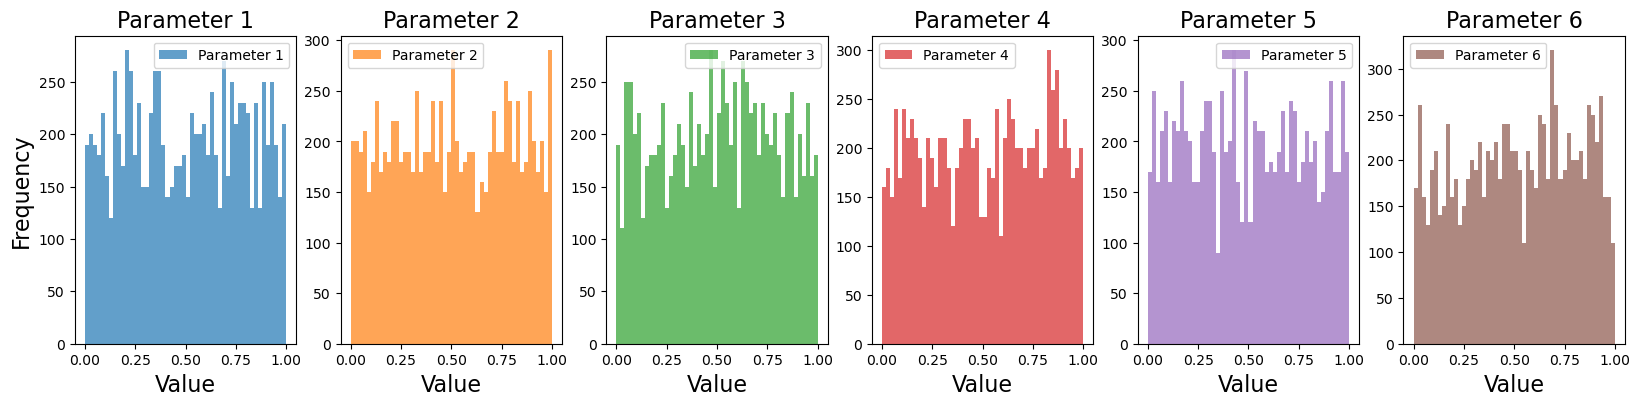

In [6]:
# Normalize function
def normalize_params(params):
    for i in range(params.shape[1]):
        minval = params[:,i].min()
        maxval = params[:,i].max()
        params[:,i] = (params[:,i] - minval) / (maxval - minval)
        print(f'Parameter {i+1}: min={minval}, max={maxval}')
    return params

# Denormalize function
def denormalize_params(norm_params, min_params, max_params):
    return norm_params * (max_params - min_params) + min_params

# Normalize the parameters
params_norm = normalize_params(params.copy())

# Visualize the parameters
import matplotlib.pyplot as plt
colors = ['C0', 'C1', 'C2', 'C3', 'C4', 'C5']
plt.figure(figsize=(20, 4))
for i in range(params_norm.shape[1]):
    plt.subplot(1, 6, i+1)
    plt.hist(params_norm[:,i], bins=50, alpha=0.7, color = colors[i])
    plt.title(f'Parameter {i+1}', fontsize=16)
    plt.xlabel('Value', fontsize=16)
    if i == 0:
        plt.ylabel('Frequency', fontsize=16)
    plt.legend([f'Parameter {i+1}'])

#### Data visualizations

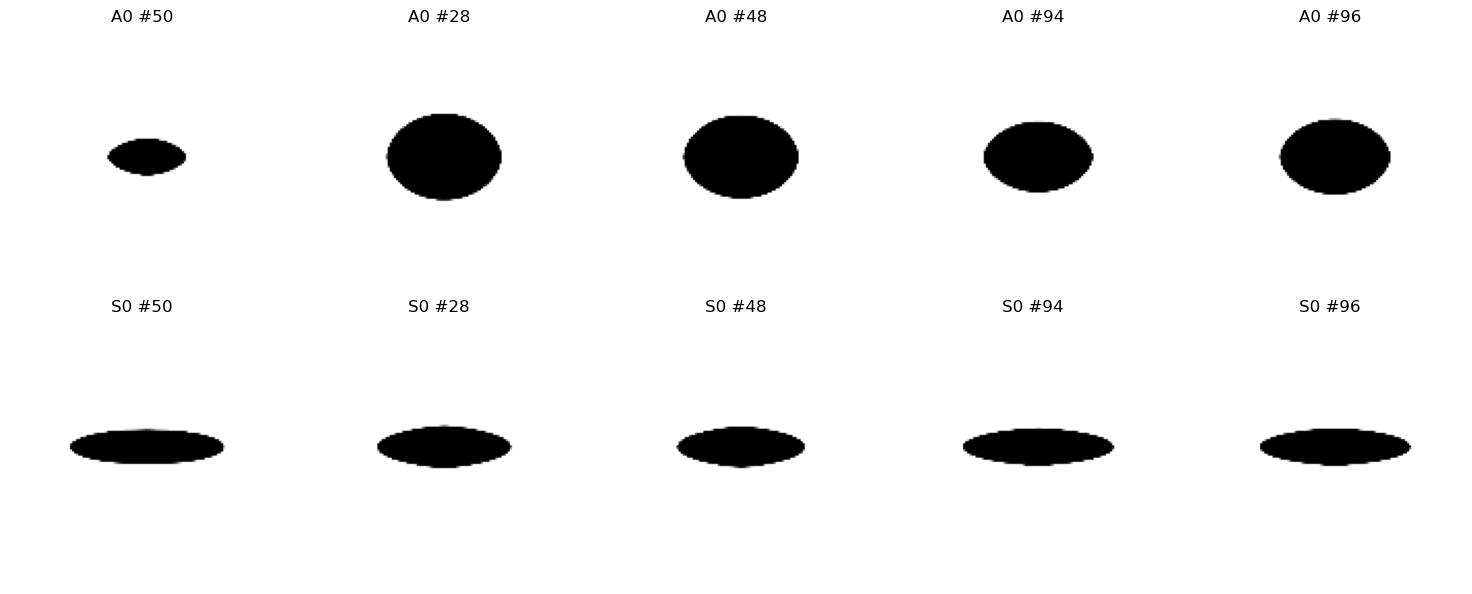

In [7]:
import numpy as np
import matplotlib.pyplot as plt

# pick 5 random indices from the first 100 (or fewer if dataset smaller)
N = min(imagesA0.shape[0], imagesS0.shape[0], 100)
idx = np.random.choice(N, 5, replace=False)

def show_img(ax, img):
    # handle HxW, HxWx1 (grayscale), or HxWx3 (RGB)
    if img.ndim == 3 and img.shape[-1] == 1:
        ax.imshow(img[..., 0], cmap='gray')
    elif img.ndim == 2:
        ax.imshow(img, cmap='gray')
    else:
        ax.imshow(img)
    ax.axis('off')

fig, axes = plt.subplots(2, 5, figsize=(15, 6))
for j, k in enumerate(idx):
    show_img(axes[0, j], imagesA0[k]); axes[0, j].set_title(f"A0 #{k}")
    show_img(axes[1, j], imagesS0[k]); axes[1, j].set_title(f"S0 #{k}")

plt.tight_layout()
plt.show()

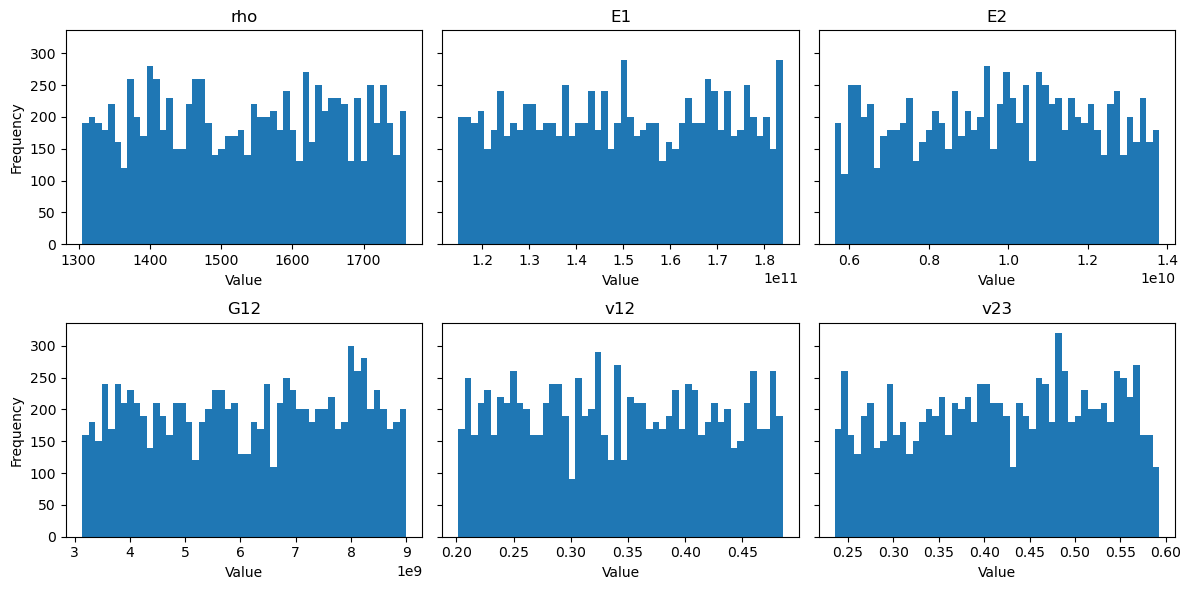

In [8]:
import matplotlib.pyplot as plt

# use whichever you created earlier (dfn_1 from your snippet, or dfn)
names = ["rho", "E1", "E2", "G12", "v12", "v23"]

fig, axes = plt.subplots(2, 3, figsize=(12, 6), sharey=True)
for i, ax in enumerate(axes.ravel()):
    ax.hist(params[:, i], bins=50)
    ax.set_title(names[i])
    ax.set_xlabel("Value")
    if i % 3 == 0:
        ax.set_ylabel("Frequency")

plt.tight_layout()
plt.show()


#### Set Up Dataloaders

In [9]:
# data-scarce and compute-scarce scenarios
dataset_size = 2500  # adjust as needed
data_idx = np.random.choice(img_merged.shape[0], dataset_size, replace=False)
print(data_idx)

[8721  288 3936 ... 7069 7587  325]


In [10]:
# Device information
import torch
print("Number of CUDA devices",torch.cuda.device_count())
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'Device: {device}')

Number of CUDA devices 1
Device: cuda


In [11]:
import torch
from torch.utils.data import Dataset, DataLoader

# dataset class
class DatasetforDataloader(Dataset):
    def __init__(self,X,y):
        self.X = X
        self.y = y
        
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self,i):
        # create a tuple
        return self.X[i], self.y[i]
    
# Dataset of dataloader
X = img_merged_uptf[data_idx]
y = params_norm[data_idx]
full_dataset = DatasetforDataloader(X, y)

# define the splits (80/10/10)
train_size = int(0.8 * dataset_size)
val_size = int(0.1 * dataset_size)
test_size = dataset_size - train_size - val_size

# Split the dataset 
train, val, test = torch.utils.data.random_split(full_dataset,[train_size, val_size, test_size])


In [12]:
# Dataloaders
BATCH_SIZE = 16
dataloader_train = DataLoader(train, batch_size = BATCH_SIZE, shuffle=True)
dataloader_val = DataLoader(val, batch_size = BATCH_SIZE, shuffle=False)
dataloader_test = DataLoader(test, batch_size = BATCH_SIZE, shuffle=False)
print(f"Number of training samples: {len(dataloader_train)}")
print(f"Number of validation samples: {len(dataloader_val)}")
print(f"Number of test samples: {len(dataloader_test)}")

Number of training samples: 125
Number of validation samples: 16
Number of test samples: 16


#### Define Models

##### Load MORPH

In [13]:
# Instantiate the foundational model
from src.utils.vit_conv_xatt_axialatt2 import ViT3DRegression

MORPH_MODELS = {
    'Ti': [8, 256,  4,  4, 1024],
    'S' : [8, 512,  8,  4, 2048],
    'M' : [8, 768, 12,  8, 3072],
    'L' : [8, 1024,16, 16, 4096]
    }

model_size = MORPH_MODELS['S']  # choose from 'Ti', 'S', 'M', 'L'
filters, dim, depth, heads, mlp_dim = model_size
heads_xa = 32
dropout = 0.1
emb_dropout = 0.1
max_ar_order = 1
patch_size = 8
max_patches = 4096
max_fields = 3
max_components = 3

# lora settings
rank_lora_attn = 16
rank_lora_mlp = 16
lora_p = 0.05

morph = ViT3DRegression(patch_size=patch_size, dim=dim, depth=depth,
    heads=heads, heads_xa=heads_xa, mlp_dim=mlp_dim,
    max_components=max_components, conv_filter=filters,
    max_ar=max_ar_order,
    max_patches=max_patches, max_fields=max_fields,
    dropout=dropout, emb_dropout=emb_dropout,
    lora_r_attn=rank_lora_attn,            # <— rank of A and B in the attention module
    lora_r_mlp=rank_lora_mlp,              # <— rank of A and B in the MLP module
    lora_alpha=None,                       # defaults to 2*rank inside LoRA
    lora_p=lora_p                          # dropout on LoRA path
).to(device)

# print('Model architecture:', ft_model)
num_params_model = sum(p.numel() for p in morph.parameters()) / 1e6
print(f"→ NUMBER OF PARAMETERS OF THE MODEL (in M): {num_params_model:.3g}")


→ NUMBER OF PARAMETERS OF THE MODEL (in M): 60.8


In [14]:
# load the foundational model weights
from huggingface_hub import hf_hub_download

# e.g., grab the "Ti" checkpoint (change filename as needed)
weights_path = hf_hub_download(
    repo_id="mahindrautela/MORPH",
    filename="morph-S-FM-max_ar1_ep225.pth",
    subfolder="models/FM",
    repo_type="model",              # optional
    resume_download=True,           # continue if interrupted
    local_dir=".",         # where to place it
    local_dir_use_symlinks=False    # copy file instead of symlink
)
print(weights_path)

c:\Users\384861\.conda\envs\pytorch_latxformer\lib\site-packages\huggingface_hub\file_download.py:942: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
c:\Users\384861\.conda\envs\pytorch_latxformer\lib\site-packages\huggingface_hub\file_download.py:979: UserWarning: `local_dir_use_symlinks` parameter is deprecated and will be ignored. The process to download files to a local folder has been updated and do not rely on symlinks anymore. You only need to pass a destination folder as`local_dir`.
For more details, check out https://huggingface.co/docs/huggingface_hub/main/en/guides/download#download-files-to-local-folder.
  warnings.warn(
'(ProtocolError('Connection aborted.', ConnectionResetError(10054, 'An existing connection was forcibly closed by the remote host', None, 10054, None)), '(Request ID: 6e26d90a-878e-42f4-be34-29700d0d90

models\FM\morph-S-FM-max_ar1_ep225.pth


In [15]:
#%% Load weights into the model
import torch.nn as nn

# ---- load the pretrained weights ----
start_epoch = 0
print(f"→ Loading checkpoints from {weights_path}")
# --- Load pretrained checkpoint from foundational model ---
ckpt = torch.load(weights_path, map_location=device, weights_only=True)
state_dict = ckpt["model_state_dict"]

# pick the real model if wrapped   
target = morph.module if isinstance(morph, nn.DataParallel) else morph 

if state_dict and next(iter(state_dict)).startswith("module."):
    print("→ Stripping 'module.' from checkpoints")
    state_dict = {k.replace("module.", "", 1): v for k, v in state_dict.items()}
    
# strict=False because ft_model has extra LoRA params (A/B) not in ckpt
missing, unexpected = target.load_state_dict(state_dict, strict=False)

# sanity print
print("Missing keys (expected: LoRA A/B etc.):",
        [k for k in missing if k.endswith((".A", ".B")) or ".lora" in k])
print("Unexpected keys:", unexpected)
print(f"→ Resumed from {weights_path}, starting at epoch {start_epoch}")


→ Loading checkpoints from models\FM\morph-S-FM-max_ar1_ep225.pth
→ Stripping 'module.' from checkpoints
Missing keys (expected: LoRA A/B etc.): ['transformer_blocks.0.axial_attn.attn_t.q.A', 'transformer_blocks.0.axial_attn.attn_t.q.B', 'transformer_blocks.0.axial_attn.attn_t.k.A', 'transformer_blocks.0.axial_attn.attn_t.k.B', 'transformer_blocks.0.axial_attn.attn_t.v.A', 'transformer_blocks.0.axial_attn.attn_t.v.B', 'transformer_blocks.0.axial_attn.attn_t.o.A', 'transformer_blocks.0.axial_attn.attn_t.o.B', 'transformer_blocks.0.axial_attn.attn_d.q.A', 'transformer_blocks.0.axial_attn.attn_d.q.B', 'transformer_blocks.0.axial_attn.attn_d.k.A', 'transformer_blocks.0.axial_attn.attn_d.k.B', 'transformer_blocks.0.axial_attn.attn_d.v.A', 'transformer_blocks.0.axial_attn.attn_d.v.B', 'transformer_blocks.0.axial_attn.attn_d.o.A', 'transformer_blocks.0.axial_attn.attn_d.o.B', 'transformer_blocks.0.axial_attn.attn_h.q.A', 'transformer_blocks.0.axial_attn.attn_h.q.B', 'transformer_blocks.0.axia

##### Task-specific head (TSH) (Simple CNN1D)

In [16]:
# Calculate number of patches and features per patch
N_patches_W = X.shape[-2] // patch_size
N_patches_H = X.shape[-1] // patch_size
N_patches = N_patches_W * N_patches_H
feat_per_patch = patch_size * patch_size * X.shape[2] * X.shape[3]
print(f'Number of patches along W: {N_patches_W}, H: {N_patches_H}, Total Patches: {N_patches} \n'
      f'Feat_per_patch (patch_size * patch_size * C * F): {feat_per_patch}')

Number of patches along W: 16, H: 16, Total Patches: 256 
Feat_per_patch (patch_size * patch_size * C * F): 128


In [17]:
# Task-specific head model
import torch
import torch.nn as nn

import torch
import torch.nn as nn

class TaskSpecificHead_CNN1D(nn.Module):
    def __init__(self, n_patches=64, feat_dim=256, output_dim=6, dropout_p=0.1):
        super().__init__()
        self.n_patches = n_patches
        self.feat_dim = feat_dim

        self.conv1 = nn.Conv1d(in_channels=feat_dim, out_channels=512, kernel_size=3, padding=1)
        self.conv2 = nn.Conv1d(in_channels=512,      out_channels=128,  kernel_size=3, padding=1)
        self.conv3 = nn.Conv1d(in_channels=128,       out_channels=32,  kernel_size=3, padding=1)

        self.act  = nn.GELU()
        self.pool = nn.MaxPool1d(kernel_size=2, stride=2)  # 64->32->16->8
        self.drop = nn.Dropout(dropout_p)

        feat_len = n_patches // 8                         # 64 -> 8
        self.fc   = nn.Linear(32 * feat_len, output_dim)  # 32*8 = 256

    def forward(self, x):
        B = x.shape[0]
        # reshape to (B, 64, 256) then permute to (B, 256, 64) for Conv1d
        #print(f"[TaskSpecificHead_CNN1D] Input x shape: {x.shape}")
        x = x.view(B, self.n_patches, self.feat_dim).permute(0, 2, 1).contiguous()
        #print(f"[TaskSpecificHead_CNN1D] Reshaped x shape: {x.shape}")
        x = self.pool(self.act(self.conv1(x)))  # (B,128,32)
        x = self.drop(x)
        x = self.pool(self.act(self.conv2(x)))  # (B, 64,16)
        x = self.drop(x)
        x = self.pool(self.act(self.conv3(x)))  # (B, 32, 8)
        x = x.flatten(1)                        # (B, 32*8 = 256)
        x = self.drop(x)
        return self.fc(x)                       # (B, output_dim)
    
# Instantiate the model - 1
output_dim = params.shape[1]  # number of parameters to predict
head = TaskSpecificHead_CNN1D(n_patches = N_patches, feat_dim = dim, output_dim = output_dim).to(device)
print("Num params encoder (in K): ", sum(p.numel()//10**3 for p in head.parameters()))
print('Model architecture', head)

Num params encoder (in K):  1000
Model architecture TaskSpecificHead_CNN1D(
  (conv1): Conv1d(512, 512, kernel_size=(3,), stride=(1,), padding=(1,))
  (conv2): Conv1d(512, 128, kernel_size=(3,), stride=(1,), padding=(1,))
  (conv3): Conv1d(128, 32, kernel_size=(3,), stride=(1,), padding=(1,))
  (act): GELU(approximate='none')
  (pool): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (drop): Dropout(p=0.1, inplace=False)
  (fc): Linear(in_features=1024, out_features=6, bias=True)
)


In [18]:
#%% Fine-tuning setup
from types import SimpleNamespace
from src.utils.select_fine_tuning_parameters import SelectFineTuningParameters

# defining arguments (similar to ft code)
def make_args(l1=False, l2=False, l3=False, l4=False, lr4=1e-4, wd4=0.0):
    return SimpleNamespace(
        ft_level1=l1, ft_level2=l2, ft_level3=l3, ft_level4=l4,
        lr_level4=lr4, wd_level4=wd4
    )

# Level-1 and Level-2 only
args = make_args(l1=True, l2=True)
selector = SelectFineTuningParameters(morph, args)
optimizer_1 = selector.configure_levels()

→ Level-1 Finetuning (latent space) activated
→ Level-2 Finetuning (Encoding) activated
[Level-1] unfrozen → LoRA(A+B): 2.753M | norms: 0.017M | pos-enc: 2.097M
[Level-2] unfrozen → conv: 0.002M | proj: 2.098M | xattn: 1.051M
→ TOTAL PARAMS (M): 60.799 | TRAINABLE (M): 8.018


In [19]:
# Optimizer for head network
import torch.optim as optim
optimizer_2 = optim.Adam(head.parameters(), lr=1e-4)

In [20]:
# Loss function
num_epochs = 100  # adjust as needed
loss_fn = nn.MSELoss()

#### Train/Finetune MORPH + TSH

In [21]:
# Trainer class
class Trainer:
    @staticmethod
    def train_epoch(dataloader_train, model_1, model_2, optimizer_1, optimizer_2, device):
        model_1.train() 
        model_2.train()
        train_loss_1 = []
        train_loss_2 = []
        for step, batch in enumerate(dataloader_train):
            x_tr, y_tr = batch
            x_tr, y_tr = x_tr.to(device), y_tr.to(device)
            #print(f'X: {x_tr.shape}, y: {y_tr.shape}')
            optimizer_1.zero_grad()
            optimizer_2.zero_grad()

            # Model 1 forward + loss
            _, z, x_nsp = model_1(x_tr)
            #print(f"[Trainer] Model 1 output shape: {x_nsp.shape}")
            #print(f"[Trainer] Model 1 latent shape: {z.shape}")
            loss_1 = loss_fn(x_nsp.unsqueeze(1), x_tr) # autoencoder loss

            # Model 1 backward
            loss_1.backward()
            optimizer_1.step()
            train_loss_1.append(loss_1.item())

            # Model 2 forward + backward
            z = z.detach() # detach the two graphs
            y_hat = model_2(z.squeeze(1))
            #print(f"[Trainer] Model 2 output shape: {y_hat.shape}")
            loss_2 = loss_fn(y_hat, y_tr)
            loss_2.backward()
            optimizer_2.step()
            train_loss_2.append(loss_2.item())

        return np.mean(train_loss_1), np.mean(train_loss_2)

    @staticmethod
    def test_epoch(dataloader_val, model_1, model_2, device):
        model_1.eval() # Set the eval mode for model
        model_2.eval()
        test_loss_1 = []
        test_loss_2 = []
        with torch.no_grad(): # No need to track the gradients
            for step, batch in enumerate(dataloader_val):
                x_val, y_val = batch
                x_val, y_val = x_val.to(device), y_val.to(device)

                # Model 1 forward
                _, z, x_nsp = model_1(x_val)
                loss_1 = loss_fn(x_nsp.unsqueeze(1), x_val)
                test_loss_1.append(loss_1.item())
                
                # Model 2 forward
                y_hat_2 = model_2(z.squeeze(1))
                loss_2 = loss_fn(y_hat_2, y_val)
                test_loss_2.append(loss_2.item())

        return np.mean(test_loss_1), np.mean(test_loss_2)

In [22]:
import time
diz_loss = {'train_loss_morph':[],'train_loss_head':[], 'val_loss_morph':[], 'val_loss_head':[]}
begin_time = time.time()
for epoch in range(num_epochs):
   train_loss_morph, train_loss_head = Trainer.train_epoch(dataloader_train, morph, head, 
                                                           optimizer_1, optimizer_2, device)
   val_loss_morph, val_loss_head = Trainer.test_epoch(dataloader_val, morph, head, device)

   print(
    f"\n EPOCH {epoch+1}/{num_epochs} TIME: {time.time()-begin_time:.2f}s, "
    f"train loss morph {train_loss_morph:.4f}, "
    f"val loss morph {val_loss_morph:.4f}, "
    f"train loss head {train_loss_head:.4f}, "
    f"val loss head {val_loss_head:.4f}"
)

   # store the losses per epoch
   diz_loss['train_loss_morph'].append(train_loss_morph)
   diz_loss['train_loss_head'].append(train_loss_head)
   diz_loss['val_loss_morph'].append(val_loss_morph)
   diz_loss['val_loss_head'].append(val_loss_head)

# Save the model
torch.save(morph.state_dict(), os.path.join(model_dir, 'morph_ft_icf.pth'))
torch.save(head.state_dict(), os.path.join(model_dir, 'head_ft_icf.pth'))


 EPOCH 1/100 TIME: 35.37s, train loss morph 0.0102, val loss morph 0.0041, train loss head 0.3858, val loss head 0.0903

 EPOCH 2/100 TIME: 72.13s, train loss morph 0.0045, val loss morph 0.0032, train loss head 0.1076, val loss head 0.1033

 EPOCH 3/100 TIME: 109.46s, train loss morph 0.0037, val loss morph 0.0028, train loss head 0.0958, val loss head 0.0774

 EPOCH 4/100 TIME: 146.61s, train loss morph 0.0033, val loss morph 0.0026, train loss head 0.0908, val loss head 0.0802

 EPOCH 5/100 TIME: 183.66s, train loss morph 0.0030, val loss morph 0.0024, train loss head 0.0853, val loss head 0.0692

 EPOCH 6/100 TIME: 221.18s, train loss morph 0.0027, val loss morph 0.0022, train loss head 0.0794, val loss head 0.0625

 EPOCH 7/100 TIME: 258.44s, train loss morph 0.0025, val loss morph 0.0021, train loss head 0.0718, val loss head 0.0576

 EPOCH 8/100 TIME: 295.72s, train loss morph 0.0023, val loss morph 0.0019, train loss head 0.0667, val loss head 0.0528

 EPOCH 9/100 TIME: 332.02

##### Plot train vs val loss

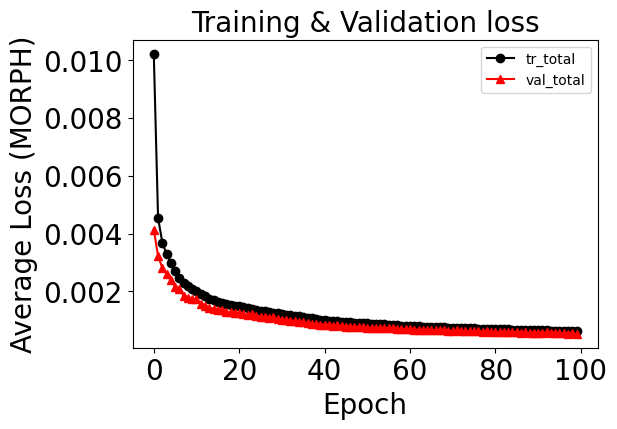

<Figure size 640x480 with 0 Axes>

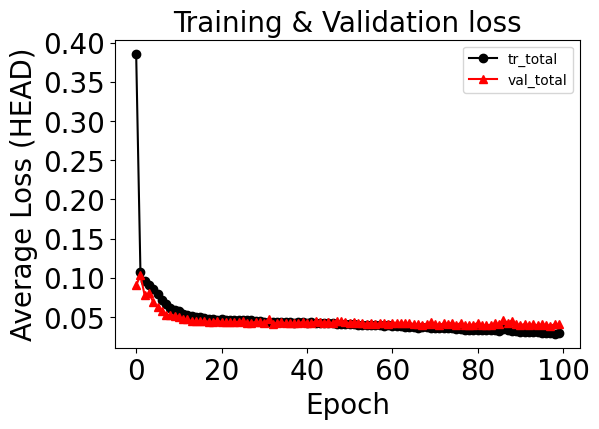

<Figure size 640x480 with 0 Axes>

In [23]:
# print train and val loss
plt.figure(figsize=(6, 4))
plt.plot(diz_loss['train_loss_morph'], '-ok', label='Train',)
plt.plot(diz_loss['val_loss_morph'], '-^r', label='Valid')
plt.xlabel('Epoch',fontsize=20)
plt.ylabel('Average Loss (MORPH)',fontsize=20)
plt.legend(["tr_total", "val_total"])
plt.title('Training & Validation loss', fontsize = 20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.show()
plt.savefig(os.path.join(results_dir, 'loss_ft_morph_icf.png'))


# print train and val loss
plt.figure(figsize=(6, 4))
plt.plot(diz_loss['train_loss_head'], '-ok', label='Train',)
plt.plot(diz_loss['val_loss_head'], '-^r', label='Valid')
plt.xlabel('Epoch',fontsize=20)
plt.ylabel('Average Loss (HEAD)',fontsize=20)
plt.legend(["tr_total", "val_total"])
plt.title('Training & Validation loss', fontsize = 20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.show()
plt.savefig(os.path.join(results_dir, 'loss_ft_head_icf.png'))

#### Testing MORPH + TSH on test set

In [24]:
# Testing
def testing(dataloader_test, model_1, model_2, device):
        model_1.eval() # Set the eval mode for model
        model_2.eval()
        mse_loss_1, mse_loss_2 = [], []
        x_org, x_pred, y_org, y_pred = [], [], [], []
        with torch.no_grad(): # No need to track the gradients
            for _, batch in enumerate(dataloader_test):
                x_test, y_test = batch
                x_test, y_test = x_test.to(device), y_test.to(device)

                # Model 1 forward
                _, z, x_nsp = model_1(x_test)
                loss_1 = loss_fn(x_nsp.unsqueeze(1), x_test)
                mse_loss_1.append(loss_1.item())
                
                # Model 2 forward
                y_hat_2 = model_2(z.squeeze(1))
                loss_2 = loss_fn(y_hat_2, y_test)
                mse_loss_2.append(loss_2.item())

                # Collect original and predicted samples
                x_org.append(x_test.cpu().numpy())
                x_pred.append(x_nsp.unsqueeze(1).cpu().numpy())
                y_org.append(y_test.cpu().numpy())
                y_pred.append(y_hat_2.cpu().numpy())

        return mse_loss_1, mse_loss_2, x_org, x_pred, y_org, y_pred

# get the test losses and predictions
mse_loss_main, mse_loss_head, x_org, x_pred, y_org, y_pred = testing(dataloader_test, morph, head, device)
print(f"Test Loss - Morph: {np.mean(mse_loss_main):.4f}, Head: {np.mean(mse_loss_head):.4f}")
print(f'x_org shape: {x_org[0].shape}, x_pred shape: {x_pred[0].shape}')
print(f'y_org shape: {y_org[0].shape}, y_pred shape: {y_pred[0].shape}')

Test Loss - Morph: 0.0005, Head: 0.0409
x_org shape: (16, 1, 1, 2, 1, 128, 128), x_pred shape: (16, 1, 1, 2, 1, 128, 128)
y_org shape: (16, 6), y_pred shape: (16, 6)


y_org shape: (250, 6), y_pred shape: (250, 6)
Parameter 1: R^2 = 0.5100, MSE = 0.0423
Parameter 2: R^2 = 0.7649, MSE = 0.0194
Parameter 3: R^2 = 0.8764, MSE = 0.0101
Parameter 4: R^2 = 0.9202, MSE = 0.0072
Parameter 5: R^2 = 0.1306, MSE = 0.0816
Parameter 6: R^2 = 0.0631, MSE = 0.0825


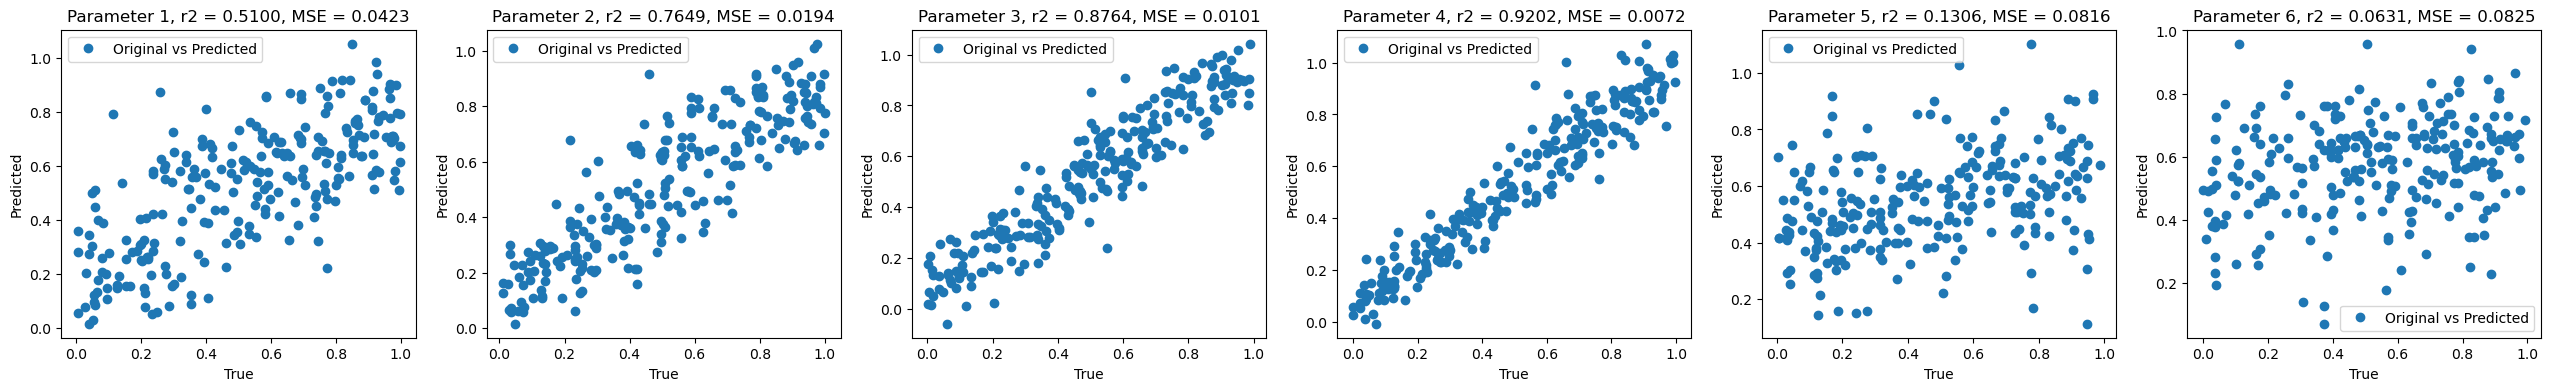

<Figure size 640x480 with 0 Axes>

In [25]:
# plot y_org vs y_pred
def plot_ytrue_vs_ypred(y_org, y_pred):
    y_org_arr = np.concatenate(y_org, axis=0)
    y_pred_arr =  np.concatenate(y_pred, axis=0)
    y_org_arr_max, y_org_arr_min  = y_org_arr.max(axis=0), y_org_arr.min(axis=0)
    print(f'y_org shape: {y_org_arr.shape}, y_pred shape: {y_pred_arr.shape}')
    plt.figure(figsize=(32, 4))
    for c in range(y_org_arr.shape[1]):
        r2 = np.corrcoef(y_org_arr[:, c], y_pred_arr[:, c])[0, 1] ** 2
        mse = np.mean((y_org_arr[:, c] - y_pred_arr[:, c])**2)
        print(f'Parameter {c+1}: R^2 = {r2:.4f}, MSE = {mse:.4f}')
        plt.subplot(1, 6, c+1)
        plt.plot(y_org_arr[:, c], y_pred_arr[:, c], 'o', label='Original vs Predicted')
        plt.title(f'Parameter {c+1}, r2 = {r2:.4f}, MSE = {mse:.4f}')
        plt.xlabel('True')
        plt.ylabel('Predicted')
        plt.legend()
    plt.show()
    plt.savefig(os.path.join(HERE, 'ytrue_vs_ypred.png'), dpi=300)

# plot for all parameters
plot_ytrue_vs_ypred(y_org, y_pred)

Number of test samples: 16, each of shape: (16, 1, 1, 2, 1, 128, 128)
Selected samples: [0 3]
Before reshape - x_o shape: (16, 2, 128, 128), x_p shape: (16, 2, 128, 128)
x_org shape: (16, 2, 128, 128), x_pred shape: (16, 2, 128, 128)


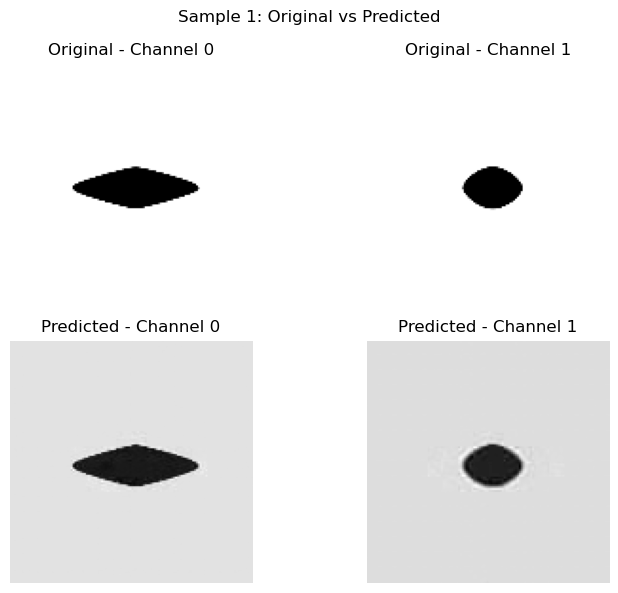

Before reshape - x_o shape: (16, 2, 128, 128), x_p shape: (16, 2, 128, 128)
x_org shape: (16, 2, 128, 128), x_pred shape: (16, 2, 128, 128)


<Figure size 640x480 with 0 Axes>

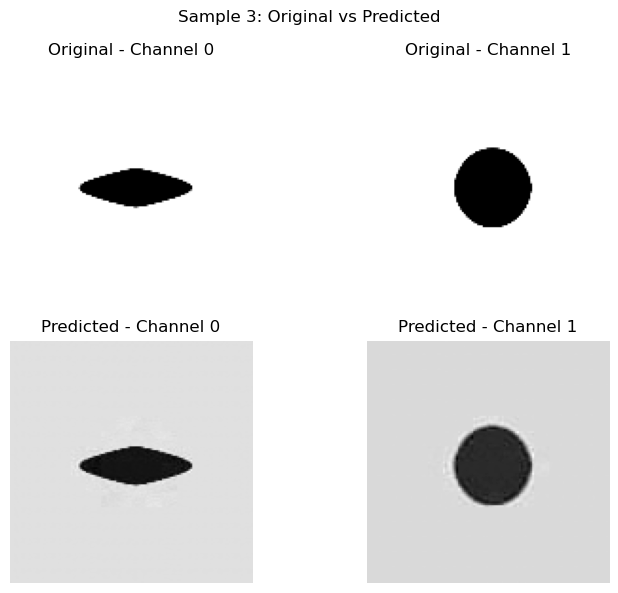

<Figure size 640x480 with 0 Axes>

In [26]:
# Plots of x_org vs x_pred
def plot_original_vs_predicted(x_org, x_pred):
    len_samples = len(x_org)
    print(f'Number of test samples: {len_samples}, each of shape: {x_org[0].shape}')
    select_samples = np.random.choice(len_samples, 2, replace=False)
    print(f'Selected samples: {select_samples}')

    for idx in select_samples:
        x_o = x_org[idx][:,0,0,:,0,:,:]       # (1, 2, 2, 1, 64, 64) -> (2, 2, 64, 64)
        x_p = x_pred[idx][:,0,0,:,0,:,:]      # (1, 2, 2, 1, 64, 64) -> (2, 2, 64, 64)
        print(f'Before reshape - x_o shape: {x_o.shape}, x_p shape: {x_p.shape}')
        x_o = x_o.reshape(-1, 2, 128, 128)      # (B, 4, 128, 128)
        x_p = x_p.reshape(-1, 2, 128, 128)      # (B, 4, 128, 128)
        print(f'x_org shape: {x_o.shape}, x_pred shape: {x_p.shape}')
        
        idx = np.random.randint(0, x_o.shape[0])  # pick a random sample from the batch
        x_o = x_o[idx]  # (2, 128, 128)
        x_p = x_p[idx]  # (22, 128, 128)

        fig, axes = plt.subplots(2, 2, figsize=(8, 6))
        for c in range(2):
            axes[0, c].imshow(x_o[c, :, :], cmap='gray', origin='lower')
            axes[0, c].set_title(f'Original - Channel {c}')
            axes[0, c].axis('off')

            axes[1, c].imshow(x_p[c, :, :], cmap='gray', origin='lower')
            axes[1, c].set_title(f'Predicted - Channel {c}')
            axes[1, c].axis('off')
        plt.suptitle(f'Sample {idx}: Original vs Predicted')
        plt.tight_layout()
        plt.show()
        plt.savefig(os.path.join(HERE, f'original_vs_predicted_sample_{idx}.png'), dpi=300)

plot_original_vs_predicted(x_org, x_pred)

## Standalone Model on ICF data

#### Standalone surrogate (SS): CNN2D encoder for regression

In [ ]:
# Standalone model
import torch.nn as nn

class Standalone_CNN2D(nn.Module):
    def __init__(self, output_dim=5):
        super(Standalone_CNN2D, self).__init__()
        # 64x64 input with 4 channels
        self.conv1 = nn.Conv2d(in_channels=4, out_channels=32, kernel_size=3, stride=1, padding=1)   # -> 32 x 64 x 64
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=2, padding=1)  # -> 64 x 32 x 32
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=2, padding=1) # -> 128 x 16 x 16
        self.conv4 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, stride=2, padding=1) # -> 256 x 8 x 8

        self.activation = nn.GELU()
        self.dropout = nn.Dropout(0.1)
        self.flatten = nn.Flatten()

        # After three 2x2 pools: 64 -> 32 -> 16 -> 8
        # So features = 256 * 8 * 8 = 16384
        self.fc1 = nn.Linear(256 * 8 * 8, 256)
        self.fc2 = nn.Linear(256, output_dim)

    def forward(self, x):
        x = self.activation(self.conv1(x))  # 32 x 64 x 64
        x = self.activation(self.conv2(x))  # 64 x 32 x 32
        x = self.activation(self.conv3(x))  # 128 x 16 x 16
        x = self.activation(self.conv4(x))  # 256 x 8 x 8
        x = self.flatten(x)                  # flatten
        x = self.activation(self.fc1(x))    # 256
        x = self.dropout(x)
        return self.fc2(x)                              # logits of shape (B, output_dim)

# Instantiate the model - 2
output_dim = params.shape[1]  # number of parameters to predict
model_ss = Standalone_CNN2D(output_dim).to(device)
print("Num params encoder (in M): ", sum(p.numel()//10**6 for p in model_ss.parameters()))
print('Model architecture', model_ss)

#### Training SS (CNN2D)

In [ ]:
# Trainer class
class Trainer2:
    @staticmethod
    def train_epoch_ss(dataloader_train, model, optimizer, device):
        model.train() 
        train_loss = []
        for step, batch in enumerate(dataloader_train):
            x_tr, y_tr = batch
            x_tr, y_tr = x_tr.to(device), y_tr.to(device)
            # print(f'X: {x_tr.shape}, y: {y_tr.shape}')
            # reshape x_tr
            x_tr = x_tr[:, 0, :, :, 0, :, :].reshape(-1, 4, 64, 64)  # (B,T,F,C,D,H,W) -> (B, 4, 64, 64)
            # print(f'X: {x_tr.shape}, y: {y_tr.shape}')

            optimizer.zero_grad()

            # Model 1 forward + loss
            y_hat = model(x_tr)
            loss = loss_fn(y_hat, y_tr) 

            # Model 1 backward
            loss.backward()
            optimizer.step()
            train_loss.append(loss.item())

        return np.mean(train_loss)

    @staticmethod
    def test_epoch_ss(dataloader_val, model, device):
        model.eval() # Set the eval mode for model
        test_loss = []
        with torch.no_grad(): # No need to track the gradients
            for step, batch in enumerate(dataloader_val):
                x_val, y_val = batch
                x_val, y_val = x_val.to(device), y_val.to(device)

                # print(f'X: {x_tr.shape}, y: {y_tr.shape}')
                # reshape x_tr
                x_val = x_val[:, 0, :, :, 0, :, :].reshape(-1, 4, 64, 64)  # (B,T,F,C,D,H,W) -> (B, 4, 64, 64)
                # print(f'X: {x_val.shape}, y: {y_val.shape}')

                # Modelforward
                y_hat = model(x_val)
                loss = loss_fn(y_hat, y_val)
                test_loss.append(loss.item())

        return np.mean(test_loss)

In [ ]:
import time
diz_loss_ss = {'train_loss':[], 'val_loss':[]}
begin_time = time.time()
for epoch in range(num_epochs):
   train_loss = Trainer2.train_epoch_ss(dataloader_train, model_ss, optimizer_2, device)
   val_loss = Trainer2.test_epoch_ss(dataloader_val, model_ss, device)

   print(
    f"\n EPOCH {epoch+1}/{num_epochs} TIME: {time.time()-begin_time:.2f}s, "
    f"train loss {train_loss:.4f}, "
    f"val loss {val_loss:.4f}"
)

   # store the losses per epoch
   diz_loss_ss['train_loss'].append(train_loss)
   diz_loss_ss['val_loss'].append(val_loss)

# Save the model
torch.save(model_ss.state_dict(), os.path.join(model_dir, 'model_ss_icf.pth'))

##### plot training and val loss for SS

In [ ]:
# print train and val loss
plt.figure(figsize=(10, 6))
plt.plot(diz_loss_ss['train_loss'], '-ok', label='Train',)
plt.plot(diz_loss_ss['val_loss'], '-^r', label='Valid')
plt.xlabel('Epoch',fontsize=20)
plt.ylabel('Average Loss',fontsize=20)
plt.legend(["tr_total", "val_total"])
plt.title('Training & Validation loss (Standalone model)', fontsize = 20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.show()
plt.savefig(os.path.join(results_dir, 'loss_ss_icf.png'))

#### Testing SS on test set

In [ ]:
# Testing
def testing_ss(dataloader_test, model, device):
        model.eval() # Set the eval mode for model
        test_loss = []
        y_org, y_pred = [], []
        with torch.no_grad(): # No need to track the gradients
            for _, batch in enumerate(dataloader_test):
                x_test, y_test = batch
                x_test, y_test = x_test.to(device), y_test.to(device)

                # print(f'X: {x_tr.shape}, y: {y_tr.shape}')
                # reshape x_tr
                x_test = x_test[:, 0, :, :, 0, :, :].reshape(-1, 4, 64, 64)  # (B,T,F,C,D,H,W) -> (B, 4, 64, 64)
                # print(f'X: {x_test.shape}, y: {y_test.shape}')

                # Model forward
                y_hat = model(x_test)
                loss = loss_fn(y_hat, y_test)
                test_loss.append(loss.item())

                # Collect original and predicted samples
                y_org.append(y_test.cpu().numpy())
                y_pred.append(y_hat.cpu().numpy())

        return test_loss, y_org, y_pred

# get the test losses and predictions
test_losses_ss, y_org_ss, y_pred_ss = testing_ss(dataloader_test, model_ss, device)
print(f'y_org shape: {y_org_ss[0].shape}, y_pred shape: {y_pred_ss[0].shape}')

In [ ]:
# plot for all parameters
plot_ytrue_vs_ypred(y_org_ss, y_pred_ss)